<a href="https://colab.research.google.com/github/rahuls569/Main_Repo/blob/main/Assignment/Assignment9/Assign_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Build the following network:

1.That takes a CIFAR10 image (32x32x3)
2.Add 3 Convolutions to arrive at AxAx48 dimensions (e.g. 32x32x3 | 3x3x3x16 >> 3x3x16x32 >> 3x3x32x48)
3. Apply GAP and get 1x1x48, call this X
4. Create a block called ULTIMUS that:
  1. Creates 3 FC layers called K, Q and V such that:
    1. X\*K = 48*48x8 > 8
    2. X\*Q = 48*48x8 > 8 
    3. X\*V = 48*48x8 > 8 
  2. then create AM = SoftMax(QTK)/(8^0.5) = 8*8 = 8
  3. then Z = V*AM = 8*8 > 8
  4. then another FC layer called Out that:
    1. Z\*Out = 8*8x48 > 48
5. Repeat this Ultimus block 4 times
6. Then add final FC layer that converts 48 to 10 and sends it to the loss function.
7. Model would look like this C>C>C>U>U>U>U>FFC>Loss
8. Train the model for 24 epochs using the OCP that I wrote in class. Use ADAM as an optimizer. 
9. Submit the link and answer the questions on the assignment page:
  1. Share the link to the main repo (must have Assignment 7/8/9 model7/8/9.py files (or similarly named))
  2. Share the code of model9.py
  3. Copy and paste the Training Log
  4. Copy and paste the training and validation loss chart1

# Loading Model from git hub



In [1]:
!pip install torch torchvision
from __future__ import print_function

# Load modules/models from EVA course

!git clone https://github.com/rahuls569/Main_Repo -q --quiet
!mv Main_Repo/* .
!rm -rf Main_Repo


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install -U git+https://github.com/albu/albumentations -q --quiet

  Preparing metadata (setup.py) ... done


# CIFAR DATASET

In [3]:
from main import *

/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [4]:
cifar10_dataset = CIFAR10Dataset('./data')
classes = cifar10_dataset.get_classes()
exp_data=cifar10_dataset.get_data()
print(classes)
exp=cifar10_dataset

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Data Statistics

In [5]:
!pip install torch_lr_finder
from utils import *
data_stats = DataStatistics(exp_data)
data_stats.print_statistics()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - min: [0. 0. 0.]
 - max: [1. 1. 1.]
 - mean: [0.49139968 0.48215841 0.44653091]
 - std: [0.24703223 0.24348513 0.26158784]
 - var: [15.56135559 15.11767693 17.44919073]


# Plotting images

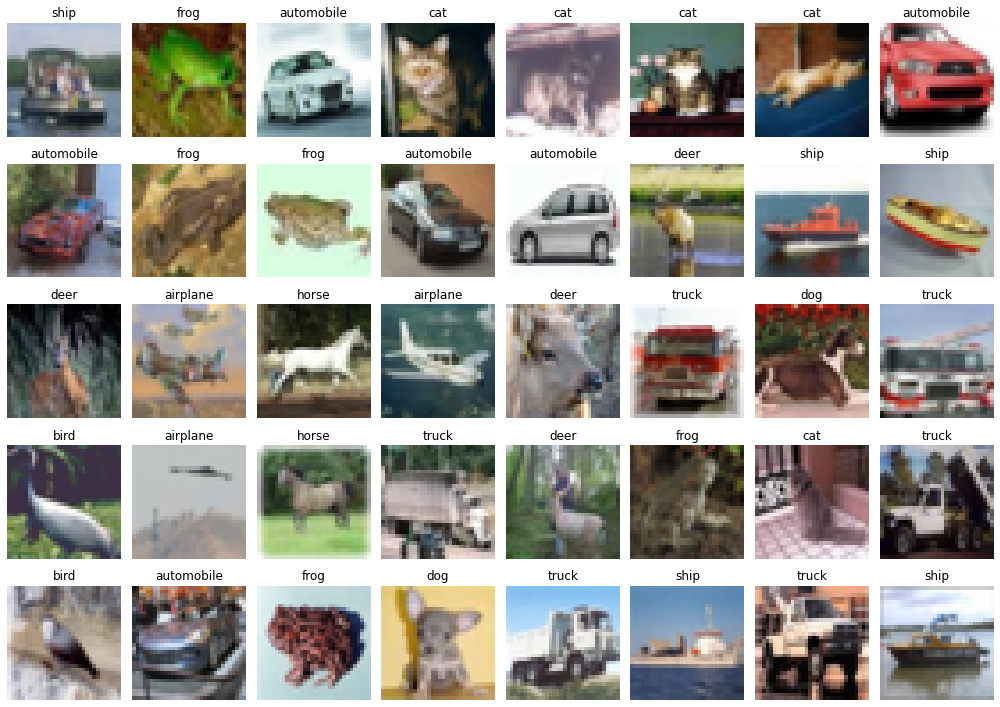

In [6]:
viz_data(cifar10_dataset, cols=8, rows=5)

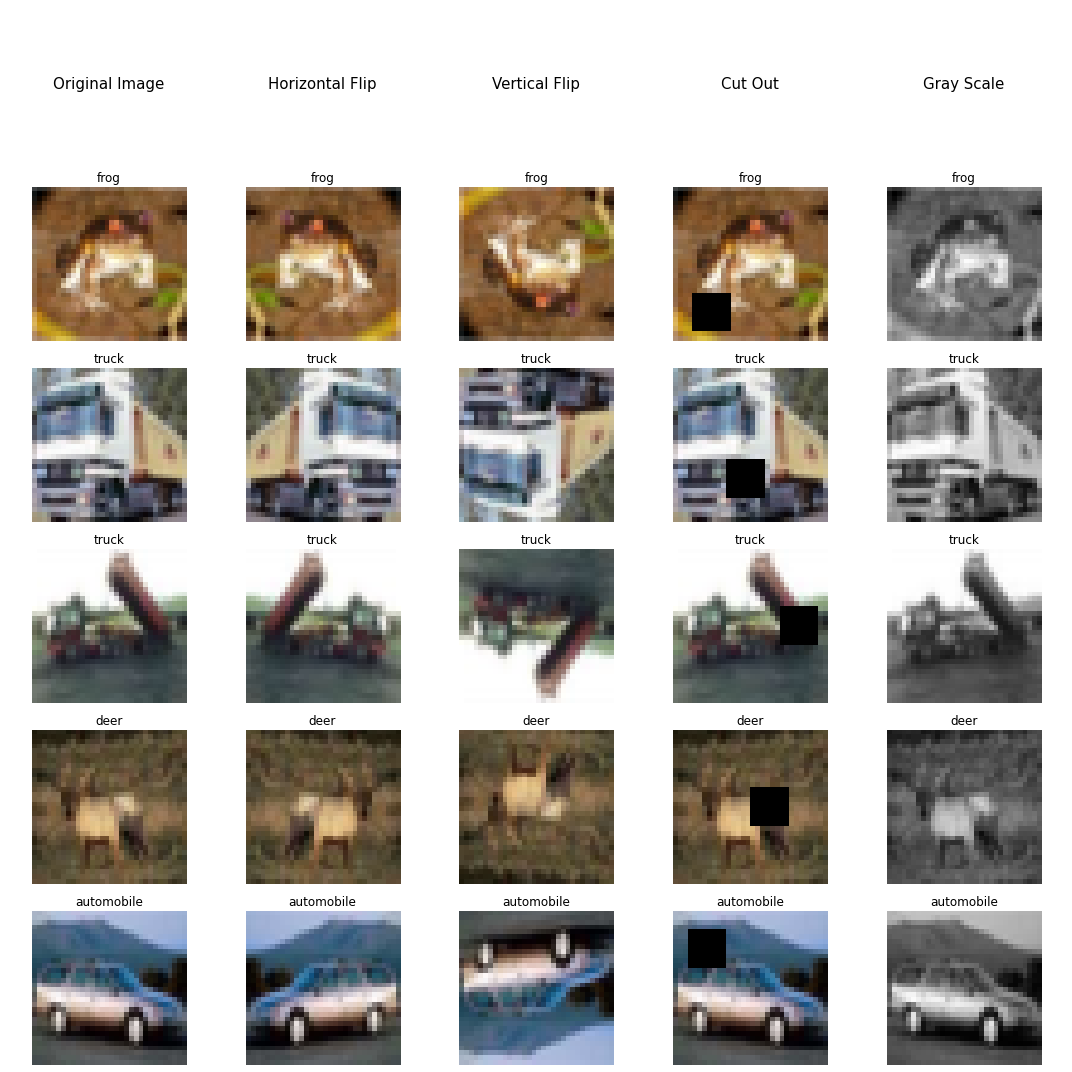

In [7]:
show_images(cifar10_dataset, {
    'Original Image': None,
    'Horizontal Flip': A.HorizontalFlip(always_apply=True),
    'Vertical Flip': A.VerticalFlip(always_apply=True),
    'Cut Out': A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, 
                               min_width=8, fill_value=0.473363, mask_fill_value=None, always_apply=True),
    'Gray Scale': A.ToGray(always_apply=True)
})

In [8]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available:", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    BATCH_SIZE=512
else:
    BATCH_SIZE=512

CUDA Available: True


# Loading train and test data with transforms and loader functions

In [9]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True )
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)


train_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(trainset, train=True), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(testset, train=False), batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


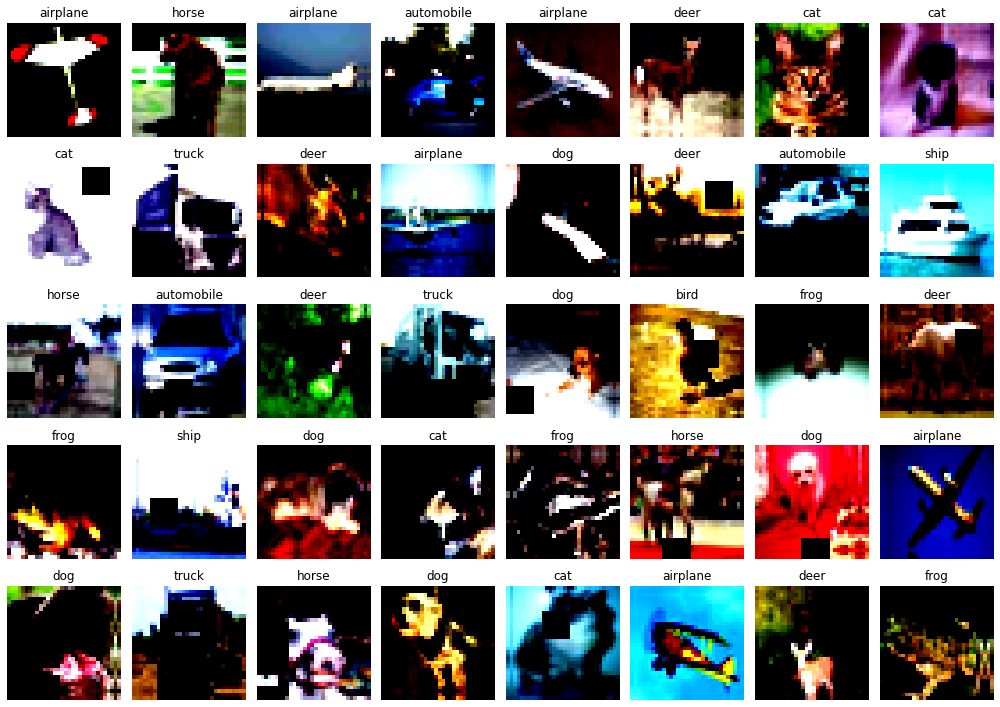

In [10]:


# Visualize training data
tain_loader_image(train_loader, classes, cols=8, rows=5)

# Load Model

In [11]:
 from models.Assignment9 import *
 import torch

In [12]:

net =Net()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

# Sending network to device
net = net.to(device)

cuda


# Torch Summary

In [13]:
!pip install torchsummary
from torchsummary import summary

# Model Summary
summary(net, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
            Conv2d-2           [-1, 32, 32, 32]           4,640
            Conv2d-3           [-1, 48, 32, 32]          13,872
 AdaptiveAvgPool2d-4             [-1, 48, 1, 1]               0
           ULTIMUS-5                   [-1, 48]               0
           ULTIMUS-6                   [-1, 48]               0
           ULTIMUS-7                   [-1, 48]               0
           ULTIMUS-8                   [-1, 48]               0
            Linear-9                   [-1, 10]             490
Total params: 19,450
Trainable params: 19,450
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.75
P

# LR for One Cycle Learning Rate

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.41E-02


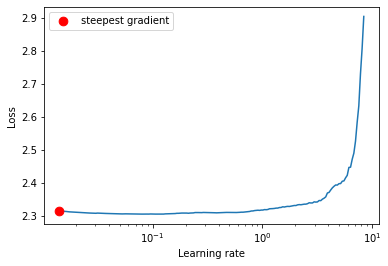

<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>

In [14]:
import copy
net_exp= copy.deepcopy(net)

optimizer = torch.optim.Adam(net_exp.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(net_exp, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=10, num_iter=200)
lr_finder.plot() 

In [15]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 0.07752597488629462


In [16]:
ler_rate

0.07752597488629462

# Training and Testing

In [17]:
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.2)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=0.2,
                                                steps_per_epoch=len(train_loader), 
                                                epochs=24,
                                                pct_start=0.208,
                                                div_factor=25,
                                                three_phase=False, 
                                                final_div_factor=100,
                                                anneal_strategy='linear'
                                                ) #final_div_factor=100,
net, history = fit_model(
    net=net, device=device,
    criterion = nn.CrossEntropyLoss(),
    train_loader=train_loader, test_loader=test_loader,
    optimizer=optimizer, 
    scheduler=scheduler, 
    NUM_EPOCHS=24
)

EPOCH: 1 (LR: 0.008)


Batch_id=97 Loss=2.30357 Accuracy=9.90%: 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]



Test set: Average loss: 2.3031, Accuracy: 1000/10000 (10.00%)

EPOCH: 2 (LR: 0.04654031821980436)


Batch_id=97 Loss=2.30445 Accuracy=9.96%: 100%|██████████| 98/98 [00:18<00:00,  5.25it/s]



Test set: Average loss: 2.3045, Accuracy: 1000/10000 (10.00%)

EPOCH: 3 (LR: 0.08508063643960873)


Batch_id=97 Loss=2.30546 Accuracy=10.00%: 100%|██████████| 98/98 [00:17<00:00,  5.69it/s]



Test set: Average loss: 2.3062, Accuracy: 1000/10000 (10.00%)

EPOCH: 4 (LR: 0.12362095465941306)


Batch_id=97 Loss=2.30663 Accuracy=10.04%: 100%|██████████| 98/98 [00:17<00:00,  5.61it/s]



Test set: Average loss: 2.3053, Accuracy: 1000/10000 (10.00%)

EPOCH: 5 (LR: 0.16216127287921744)


Batch_id=97 Loss=2.30752 Accuracy=10.07%: 100%|██████████| 98/98 [00:17<00:00,  5.71it/s]



Test set: Average loss: 2.3081, Accuracy: 1000/10000 (10.00%)

EPOCH: 6 (LR: 0.19980853535353535)


Batch_id=97 Loss=2.30851 Accuracy=10.04%: 100%|██████████| 98/98 [00:17<00:00,  5.59it/s]



Test set: Average loss: 2.3093, Accuracy: 1000/10000 (10.00%)

EPOCH: 7 (LR: 0.1892908585858586)


Batch_id=97 Loss=2.30848 Accuracy=9.94%: 100%|██████████| 98/98 [00:17<00:00,  5.73it/s]



Test set: Average loss: 2.3107, Accuracy: 1000/10000 (10.00%)

EPOCH: 8 (LR: 0.17877318181818183)


Batch_id=97 Loss=2.30834 Accuracy=9.88%: 100%|██████████| 98/98 [00:17<00:00,  5.56it/s]



Test set: Average loss: 2.3042, Accuracy: 1000/10000 (10.00%)

EPOCH: 9 (LR: 0.16825550505050507)


Batch_id=97 Loss=2.30818 Accuracy=10.22%: 100%|██████████| 98/98 [00:16<00:00,  5.81it/s]



Test set: Average loss: 2.3042, Accuracy: 1000/10000 (10.00%)

EPOCH: 10 (LR: 0.15773782828282829)


Batch_id=97 Loss=2.30750 Accuracy=10.00%: 100%|██████████| 98/98 [00:17<00:00,  5.70it/s]



Test set: Average loss: 2.3055, Accuracy: 1000/10000 (10.00%)

EPOCH: 11 (LR: 0.14722015151515153)


Batch_id=97 Loss=2.30611 Accuracy=10.18%: 100%|██████████| 98/98 [00:17<00:00,  5.66it/s]



Test set: Average loss: 2.3051, Accuracy: 1000/10000 (10.00%)

EPOCH: 12 (LR: 0.13670247474747477)


Batch_id=97 Loss=2.30670 Accuracy=9.95%: 100%|██████████| 98/98 [00:17<00:00,  5.67it/s]



Test set: Average loss: 2.3060, Accuracy: 1000/10000 (10.00%)

EPOCH: 13 (LR: 0.12618479797979798)


Batch_id=97 Loss=2.30682 Accuracy=9.82%: 100%|██████████| 98/98 [00:17<00:00,  5.71it/s]



Test set: Average loss: 2.3045, Accuracy: 1000/10000 (10.00%)

EPOCH: 14 (LR: 0.11566712121212121)


Batch_id=97 Loss=2.30532 Accuracy=9.97%: 100%|██████████| 98/98 [00:17<00:00,  5.65it/s]



Test set: Average loss: 2.3063, Accuracy: 1000/10000 (10.00%)

EPOCH: 15 (LR: 0.10514944444444443)


Batch_id=97 Loss=2.30597 Accuracy=9.89%: 100%|██████████| 98/98 [00:17<00:00,  5.52it/s]



Test set: Average loss: 2.3035, Accuracy: 1000/10000 (10.00%)

EPOCH: 16 (LR: 0.09463176767676768)


Batch_id=97 Loss=2.30511 Accuracy=9.64%: 100%|██████████| 98/98 [00:17<00:00,  5.68it/s]



Test set: Average loss: 2.3037, Accuracy: 1000/10000 (10.00%)

EPOCH: 17 (LR: 0.08411409090909092)


Batch_id=97 Loss=2.30470 Accuracy=9.91%: 100%|██████████| 98/98 [00:18<00:00,  5.36it/s]



Test set: Average loss: 2.3038, Accuracy: 1000/10000 (10.00%)

EPOCH: 18 (LR: 0.07359641414141413)


Batch_id=97 Loss=2.30458 Accuracy=9.75%: 100%|██████████| 98/98 [00:17<00:00,  5.74it/s]



Test set: Average loss: 2.3035, Accuracy: 1000/10000 (10.00%)

EPOCH: 19 (LR: 0.06307873737373737)


Batch_id=97 Loss=2.30434 Accuracy=10.15%: 100%|██████████| 98/98 [00:18<00:00,  5.40it/s]



Test set: Average loss: 2.3042, Accuracy: 1000/10000 (10.00%)

EPOCH: 20 (LR: 0.05256106060606061)


Batch_id=97 Loss=2.30399 Accuracy=9.94%: 100%|██████████| 98/98 [00:17<00:00,  5.65it/s]



Test set: Average loss: 2.3036, Accuracy: 1000/10000 (10.00%)

EPOCH: 21 (LR: 0.04204338383838385)


Batch_id=97 Loss=2.30392 Accuracy=9.89%: 100%|██████████| 98/98 [00:18<00:00,  5.36it/s]



Test set: Average loss: 2.3030, Accuracy: 1000/10000 (10.00%)

EPOCH: 22 (LR: 0.031525707070707065)


Batch_id=97 Loss=2.30369 Accuracy=9.91%: 100%|██████████| 98/98 [00:17<00:00,  5.62it/s]



Test set: Average loss: 2.3032, Accuracy: 1000/10000 (10.00%)

EPOCH: 23 (LR: 0.021008030303030306)


Batch_id=97 Loss=2.30313 Accuracy=9.91%: 100%|██████████| 98/98 [00:18<00:00,  5.25it/s]



Test set: Average loss: 2.3028, Accuracy: 1000/10000 (10.00%)

EPOCH: 24 (LR: 0.01049035353535352)


Batch_id=97 Loss=2.30285 Accuracy=9.72%: 100%|██████████| 98/98 [00:17<00:00,  5.65it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)



#GRAPH LOSS and ACCURACY

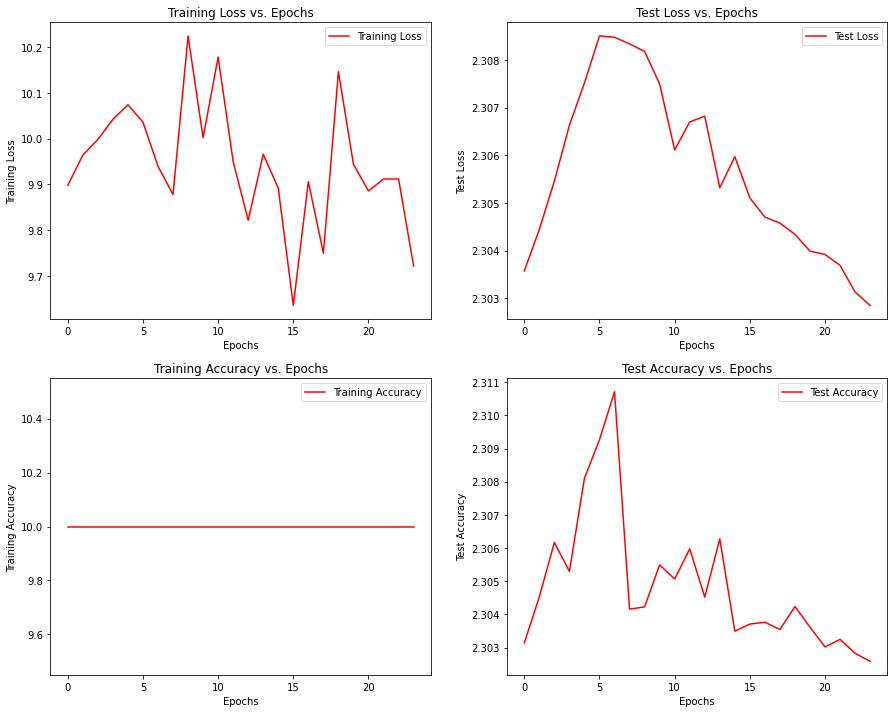

In [18]:
Graph_loss_accuracy_one_cycle(history)

In [19]:
ler_rate / (25 * 50)

6.20207799090357e-05